In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
%pwd

In [2]:
%cd drive/MyDrive/QLI_Lab_Project/video_processing

/content/drive/MyDrive/QLI_Lab_Project/video_processing


In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import pandas as pd

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.linear_relu_stack = nn.Sequential( # this NN took 100 epochs to 
        #                                        # achieve the same level as other
        #                                        # neural networks with less neurons
        #     nn.Linear(1080, 512), # (19584, 1080) * (1080, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 256), # (1080, 512) * (512, 256) = (1080, 256)
        #     nn.ReLU(),
        #     nn.Linear(256, 128), 
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 16),
        #     nn.ReLU(),
        #     nn.Linear(16, 8),
        #     nn.ReLU(),
        #     nn.Linear(8, 1),
        # )
        # self.linear_relu_stack1 = nn.Sequential(
        #     nn.Linear(1080, 512), # (19584, 1080) * (1080, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 512), # (1080, 512) * (512, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 1), 
        # )
        # self.linear_relu_stack2 = nn.Sequential( # did not work very well
        #     nn.Linear(1080, 512), # (19584, 1080) * (1080, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 512), # (1080, 512) * (512, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 512), # (1080, 512) * (512, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(512, 1), 
        # )
        # self.linear_relu_stack3 = nn.Sequential( # model doesn't adjust parameters by much
        #     nn.Linear(1080, 1080), # (19584, 1080) * (1080, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(1080, 1), # (1080, 512) * (512, 512) = (1080, 512)
        #     nn.Sigmoid(),
        # )
        # self.linear_relu_stack4 = nn.Sequential( # after 50 epochs, loss was about 8000
        #     nn.Linear(1080, 100), # (19584, 1080) * (1080, 512) = (1080, 512)
        #     nn.ReLU(),
        #     nn.Linear(100, 1), # (1080, 512) * (512, 512) = (1080, 512),
        #     nn.Sigmoid(),
        # )
        self.linear_relu_stack5 = nn.Sequential( # after 50 epochs, loss was about 4000
            nn.Linear(1080, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )
        # self.linear_relu_stack6 = nn.Sequential(
        #     nn.Linear(1080, 20),
        #     nn.ReLU(),
        #     nn.Linear(20, 20),
        #     nn.ReLU(),
        #     nn.Linear(20, 1),
        #     nn.Sigmoid(),
        # )

    def forward(self, x):
        # logits = self.linear_relu_stack(x)
        # logits = self.linear_relu_stack1(x)
        # logits = self.linear_relu_stack2(x)
        # logits = self.linear_relu_stack3(x) * 180
        # logits = self.linear_relu_stack4(x) * 180
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack5(x) * 180
        # logits = self.linear_relu_stack6(x) * 180
        return logits

model = NeuralNetwork()

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    xtrain, ytrain = dataloader['train']
    idxs = np.arange(xtrain.shape[0])
    np.random.shuffle(idxs) # shuffles indices in place
    X = xtrain[idxs]  # random batch of our training data
    y = ytrain[idxs]

    # `model.__call__ is responsible for performing the "forward-pass"
    pred = model(X) 
    loss = loss_fn(pred, y)
    # print(pred)
    # print(y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"loss: {loss.item():>7f}")
    return loss.item()

        
def test_loop(dataloader, model, loss_fn):
    with torch.no_grad():
        xtest, ytest = dataloader['test']
        idxs = np.arange(xtest.shape[0])
        np.random.shuffle(idxs)
        X = xtest[idxs]  # random batch of our training data
        y = ytest[idxs]
        # `model.__call__ is responsible for performing the "forward-pass"
        pred = model(X) 
        loss = loss_fn(pred, y)
        # print(pred)
        # print(y)
        # print('loss', torch.mean((pred - y) ** 2))
        print(f"loss: {loss.item():>7f}")
    return loss.item()

In [8]:
data_path = Path('hists')
xtrain = []
ytrain = []
xtest = []
ytest = []
for hists_path in data_path.glob('*'):
        hists = np.load(str(hists_path))
        theta = int(str(hists_path).split("_")[1])
        xtrain.append(hists[:int(hists.shape[0] * 0.8), :]) # shape (1440 * 0.8 = 1152, 1080)
        ytrain.append([theta] * int(hists.shape[0] * 0.8)) # shape (1440 * 0.8 = 1152,)
        xtest.append(hists[int(hists.shape[0] * 0.8):, :]) # shape (1440 * 0.2 = 288, 1080)
        ytest.append([theta] * int(hists.shape[0] * 0.2)) # shape (1440 * 0.2 = 288,)
xtrain = np.vstack(np.array(xtrain).squeeze()) # shape (1440 * 0.8 * 17 = 19584, 1080)
ytrain = np.array(ytrain).ravel().reshape(-1,1) # shape (1440 * 0.8 * 17 = 19584,)
xtest = np.vstack(np.array(xtest).squeeze()) # shape (1440 * 0.2 * 17 = 4896, 1080)
ytest = np.array(ytest).ravel().reshape(-1,1) # shape (1440 * 0.2 * 17 = 4896,)
# Normalizing everything
xtrain_normalized = (xtrain - xtrain.mean()) / xtrain.std()
# ytrain_normalized = (ytrain - ytrain.mean()) / ytrain.std()
xtest_normalized = (xtest - xtrain.mean()) / xtrain.std()
# ytest_normalized = (ytest - ytrain.mean()) / ytrain.std()
dataloader = {}
# dataloader['train'] = [torch.from_numpy(xtrain).float(), torch.from_numpy(ytrain).float()]
# dataloader['test'] = [torch.from_numpy(xtest).float(), torch.from_numpy(ytest).float()]
dataloader['train'] = [torch.from_numpy(xtrain_normalized).float(), torch.from_numpy(ytrain).float()]
dataloader['test'] = [torch.from_numpy(xtest_normalized).float(), torch.from_numpy(ytest).float()]
# dataloader['train'] = [torch.from_numpy(xtrain_normalized).float(), torch.from_numpy(ytrain_normalized).float()]
# dataloader['test'] = [torch.from_numpy(xtest_normalized).float(), torch.from_numpy(ytest_normalized).float()]

In [ ]:
print(f'Mean: {xtrain.mean()}, Std: {xtrain.std()}')

Mean: 4.827662698953038, Std: 22.350584800469168


In [ ]:
xtrain[0, 0:20]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 3.,
       3., 3., 6.])

In [ ]:
torch.from_numpy(xtrain_normalized).float()

tensor([[-0.0818, -0.0818, -0.0818,  ..., -0.2160, -0.0370, -0.0370],
        [-0.2160, -0.2160, -0.2160,  ..., -0.0370, -0.0818, -0.0818],
        [-0.2160, -0.2160, -0.2160,  ..., -0.0818, -0.0818,  0.0525],
        ...,
        [-0.2160, -0.2160, -0.2160,  ..., -0.0818, -0.0818, -0.0818],
        [-0.2160, -0.2160, -0.2160,  ..., -0.2160, -0.2160, -0.0818],
        [-0.2160, -0.2160, -0.2160,  ..., -0.2160, -0.2160, -0.2160]])

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

torch.Size([19584, 1080])
torch.Size([19584, 1])
torch.Size([4896, 1080])
torch.Size([4896, 1])


In [10]:
loss_fn = nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
train_losses = []
test_losses = []
# train_losses = train_losses.tolist()
# test_losses = test_losses.tolist()
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    test_loss = test_loop(dataloader, model, loss_fn)
    test_losses.append(test_loss)
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 4856.015625
loss: 4810.825195
Epoch 2
-------------------------------
loss: 4815.416504
loss: 4740.501465
Epoch 3
-------------------------------
loss: 4746.616211
loss: 4691.021484
Epoch 4
-------------------------------
loss: 4698.280273
loss: 4661.359863
Epoch 5
-------------------------------
loss: 4668.837402
loss: 4639.944336
Epoch 6
-------------------------------
loss: 4646.407715
loss: 4626.258789
Epoch 7
-------------------------------
loss: 4630.691406
loss: 4620.298828
Epoch 8
-------------------------------
loss: 4622.012695
loss: 4617.342773
Epoch 9
-------------------------------
loss: 4615.518555
loss: 4611.812500
Epoch 10
-------------------------------
loss: 4606.373047
loss: 4601.606934
Done!


In [ ]:
train_loss

3850.531005859375

In [ ]:
print(train_loss ** 0.5) # on average, it guesses +/- 130º from the correct answer
print(test_loss ** 0.5)

57.21689604792779
63.135839879926756


In [ ]:
print(train_loss ** 0.5) # on average, it guesses +/- 130º from the correct answer
print(test_loss ** 0.5)

56.475323444873915
62.92549693139102


In [ ]:
print(train_loss ** 0.5) # on average, it guesses +/- 130º from the correct answer
print(test_loss ** 0.5)

62.011944020260124
64.6352181537376


In [ ]:
len(train_losses)

100

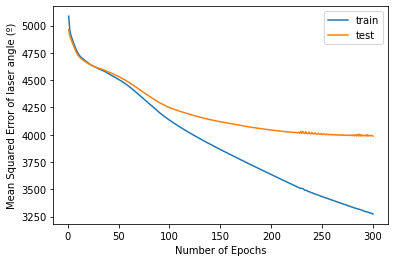

In [ ]:
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train')
plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label='test')
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Squared Error of laser angle (º)")
plt.legend()
# plt.savefig('models_loss_graphs/model_4_epochs_250')
# plt.savefig('models_loss_graphs/model_5_epochs_300_lr_5x10-4')

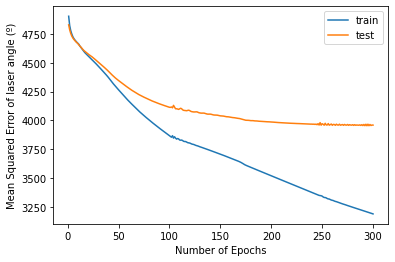

In [ ]:
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='train')
plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label='test')
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Squared Error of laser angle (º)")
plt.legend()
# plt.savefig('models_loss_graphs/model_4_epochs_250')
# plt.savefig('models_loss_graphs/model_5_epochs_300_lr_5x10-4')

In [ ]:
PATH = "models/model_5_epochs_300_lr_5x10-4.pt"
PATH = "models/model_4_epochs_700_lr_5x10-4.pt"
# torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

NeuralNetwork(
  (linear_relu_stack5): Sequential(
    (0): Linear(in_features=1080, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
with torch.no_grad():
    xtest, ytest = dataloader['test']
    idxs = np.arange(xtest.shape[0])
    np.random.shuffle(idxs)
    X = xtest[idxs]  # random batch of our training data
    y = ytest[idxs]
    # `model.__call__ is responsible for performing the "forward-pass"
    pred = model(X) 
    loss = loss_fn(pred, y)
    print(np.hstack([pred[:20], y[:20]]))
    print()
    print(pred.min(), pred.max())
    print("MSE loss", loss)
    print("ME loss", loss ** 0.5)

[[ 96.48866  150.      ]
 [ 66.379684  20.      ]
 [118.4417   178.      ]
 [ 72.53448  177.      ]
 [154.6866   150.      ]
 [ 97.04248  177.      ]
 [157.13385  160.      ]
 [111.605      0.      ]
 [ 77.67591  160.      ]
 [170.1825   140.      ]
 [ 67.90369   50.      ]
 [ 89.56073   30.      ]
 [ 69.97894   20.      ]
 [ 92.14538   30.      ]
 [ 27.392288  40.      ]
 [ 94.468506 176.      ]
 [ 89.068375 179.      ]
 [128.75937    0.      ]
 [159.49197  150.      ]
 [144.8223   140.      ]]

tensor(0.0012) tensor(179.9961)
MSE loss tensor(4100.9194)
ME loss tensor(64.0384)


Below is "99% chance of being useless" code

In [ ]:
# self.linear_relu_stack2 = nn.Sequential(
#             nn.Linear(1080, 720), # (19584, 1080) * (1080, 512) = (1080, 512)
#             nn.ReLU(),
#             nn.Linear(720, 540), # (1080, 512) * (512, 256) = (1080, 256)
#             nn.ReLU(),
#             nn.Linear(540, 360), 
#             nn.ReLU(),
#             nn.Linear(360, 240),
#             nn.ReLU(),
#             nn.Linear(240, 160),
#             nn.ReLU(),
#             nn.Linear(160, 53),
#             nn.ReLU(),
#             nn.Linear(53, 36),
#             nn.ReLU(),
#             nn.Linear(36, 24),
#             nn.ReLU(),
#             nn.Linear(24, 16),
#             nn.ReLU(),
#             nn.Linear(16, 10),
#             nn.ReLU(),
#             nn.Linear(10, 6),
#             nn.ReLU(),
#             nn.Linear(6, 4),
#             nn.ReLU(),
#             nn.Linear(4, 1),
#             nn.ReLU(),
#         )